In [25]:
import os
from nilearn import image as img
from nilearn import plotting as plot
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
%matplotlib inline

In [26]:
import pandas as pd

In [27]:
#Load func data, confounds, mask (mfcc003 n1)

func_dir = '/Volumes/Seagate_Desktop_Drive/MFC_fMRIPREP/derivatives/fmriprep/sub-mfcc003/func'  #subject folder

func = os.path.join(func_dir, 'sub-mfcc003_task-n1_acq-epi_rec-fmap_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
confound = os.path.join(func_dir, 'sub-mfcc003_task-n1_acq-epi_rec-fmap_desc-confounds_timeseries.tsv')
mask = os.path.join(func_dir, 'sub-mfcc003_task-n1_acq-epi_rec-fmap_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz')

In [28]:
confound

'/Volumes/Seagate_Desktop_Drive/MFC_fMRIPREP/derivatives/fmriprep/sub-mfcc003/func/sub-mfcc003_task-n1_acq-epi_rec-fmap_desc-confounds_timeseries.tsv'

In [29]:
#Delimiter is \t --> tsv is tab-separated spreadsheet

confound_df = pd.read_csv(confound, delimiter = '\t')
confound_df.head()
#print(confound_df.shape)

,global_signal,global_signal_derivative1,global_signal_power2,global_signal_derivative1_power2,csf,csf_derivative1,csf_derivative1_power2,csf_power2,white_matter,white_matter_derivative1,...,aroma_motion_37,aroma_motion_38,aroma_motion_40,aroma_motion_41,aroma_motion_42,aroma_motion_43,aroma_motion_44,aroma_motion_46,aroma_motion_48,aroma_motion_49
0,386.268412,NaN,149203.286258,NaN,550.376007,NaN,NaN,302913.748929,433.425929,NaN,...,2.786552,0.064860,1.537599,6.655496,1.609656,0.722685,0.664279,3.672509,-1.411883,-1.882258
1,385.158055,-1.110357,148346.727658,1.232892,544.823159,-5.552848,30.834115,296832.274971,433.963340,0.537411,...,1.842812,-1.483322,1.032655,2.799931,-1.352584,0.369831,-0.085305,1.954092,-1.588387,0.001897
2,385.652658,0.494603,148727.972677,0.244632,544.093431,-0.729728,0.532503,296037.662061,433.379436,-0.583905,...,2.009120,-1.192041,1.637222,0.786883,1.095655,2.547383,-1.465357,1.819484,-1.582786,-1.643870
3,386.024833,0.372175,149015.171752,0.138514,544.458091,0.364660,0.132977,296434.613217,433.640556,0.261121,...,2.564678,0.657851,2.039972,-1.529832,1.146393,0.235099,0.620638,2.924234,-0.299614,-0.900176
4,385.221218,-0.803615,148395.386771,0.645797,543.266213,-1.191878,1.420573,295138.178641,433.228017,-0.412540,...,1.028832,-1.046303,1.090595,-0.791093,0.338141,0.264870,0.935427,2.874827,0.366104,-1.095703


In [7]:
# Pre-processing Pipeline (Yeo 2011):

# regress 6 motion (xyz rot.xyz) + 6 derivatives, GS, aCompCor01-02
# lo/hi pass filtering
# drop dummy TRs

In [11]:
# Set up confound vars for regression

#select confound vars from df
confound_vars = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','global_signal','a_comp_cor_00','a_comp_cor_01']
confound_df = confound_df[confound_vars]
confound_df.head()

#compute temporal derivatives
for col in confound_df.columns:
    
    #Example X --> X_dt
    new_name = '{}_dt'.format(col)
    
    #Compute differences for each pair of rows from start to end
    new_col = confound_df[col].diff()
    
    #Make new col in df
    confound_df[new_name] = new_col

confound_df.head()

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,global_signal,a_comp_cor_00,a_comp_cor_01,trans_x_dt,trans_y_dt,trans_z_dt,rot_x_dt,rot_y_dt,rot_z_dt,global_signal_dt,a_comp_cor_00_dt,a_comp_cor_01_dt
0,-0.067680,-0.169438,-0.134994,0.001652,-0.002165,-0.001413,386.268412,-0.034492,-0.354604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.051072,-0.117220,-0.081370,0.000952,-0.001885,-0.001083,385.158055,0.067611,-0.021881,0.016607,0.052218,0.053624,-0.000700,0.000280,0.000330,-1.110357,0.102103,0.332723
2,-0.051027,-0.046660,-0.073958,0.000337,-0.001544,-0.000818,385.652658,0.095730,-0.123477,0.000046,0.070560,0.007412,-0.000615,0.000340,0.000265,0.494603,0.028118,-0.101597
3,-0.040603,-0.134480,-0.062433,0.000797,-0.001130,-0.000945,386.024833,-0.022571,-0.132665,0.010424,-0.087820,0.011526,0.000460,0.000414,-0.000127,0.372175,-0.118301,-0.009188
4,-0.029434,-0.060439,-0.054685,0.000470,-0.001130,-0.000842,385.221218,-0.111986,-0.021465,0.011169,0.074041,0.007748,-0.000327,0.000000,0.000102,-0.803615,-0.089414,0.111201


In [12]:
# Drop Dummy TRs (1st 4)

#load data, check shape
raw_func_img = img.load_img(func)
raw_func_img.shape

(49, 58, 49, 147)

In [14]:
#get all timepoints after the 4th
func_img = raw_func_img.slicer[:,:,:,5:]
func_img.shape

(49, 58, 49, 142)

In [15]:
#drop confound dummy TRs from df to match size of new func_img
drop_confound_df = confound_df.loc[5:]
print(drop_confound_df.shape) #num of rows should match func img
drop_confound_df.head()

(142, 18)


,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,global_signal,a_comp_cor_00,a_comp_cor_01,trans_x_dt,trans_y_dt,trans_z_dt,rot_x_dt,rot_y_dt,rot_z_dt,global_signal_dt,a_comp_cor_00_dt,a_comp_cor_01_dt
5,-0.023293,-0.103484,-0.048866,0.000909,-0.001047,-0.000736,386.127694,0.093717,0.019065,0.006142,-0.043045,0.005818,0.000439,0.000083,0.000107,0.906476,0.205703,0.040530
6,-0.010838,-0.165615,-0.094358,0.001626,-0.001248,-0.000534,386.113491,0.071241,-0.098113,0.012454,-0.062131,-0.045492,0.000717,-0.000200,0.000202,-0.014203,-0.022476,-0.117178
7,-0.005483,-0.062025,-0.074207,0.000274,-0.000833,-0.000480,385.382783,0.001525,-0.111793,0.005356,0.103590,0.020151,-0.001352,0.000414,0.000053,-0.730707,-0.069716,-0.013679
8,-0.010857,-0.120497,-0.024997,0.000381,-0.000725,-0.000245,385.038814,-0.110161,-0.015807,-0.005374,-0.058472,0.049211,0.000107,0.000108,0.000235,-0.343969,-0.111686,0.095986
9,-0.010907,-0.148140,-0.019393,0.000841,-0.000545,-0.000232,384.111811,-0.100901,0.123359,-0.000050,-0.027643,0.005604,0.000460,0.000179,0.000014,-0.927004,0.009259,0.139167


In [16]:
# Apply Confound Regression

In [19]:
#build confounds matrix for nilearn.image.clean_img(image,confounds,...)
confounds_matrix = drop_confound_df.to_numpy()
#confirm matrix size is correct
confounds_matrix.shape

(142, 18)

In [21]:
# nilearn.image.clean_img(image,confounds,[low_pass],[high_pass],[t_r],[mask_img],[detrend],[standardize])

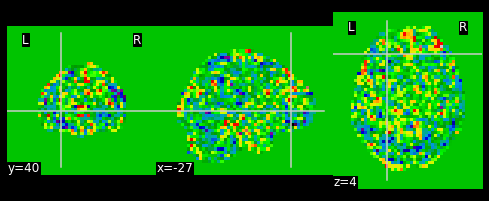

In [24]:
# set up constants
high_pass = 0.009
t_r = 2

# regress (confounds,detrend,standardize,hipass,mask)
clean_img = img.clean_img(func_img, confounds=confounds_matrix, detrend=True, standardize=True, high_pass=high_pass, t_r=t_r, mask_img=mask)

# visualize
plot.plot_epi(clean_img.slicer[:,:,:,50])